## Prédisez la demande en électricité

Vous vous concentrerez uniquement sur la prédiction de la demande en électricité.

1. Corrigez les données de consommation mensuelles de l'effet température (dues au chauffage électrique) en utilisant une régression linéaire.

2. Effectuez une désaisonnalisation de la consommation que vous aurez obtenue après correction, grâce aux moyennes mobiles.
3. Effectuez une prévision de la consommation (corrigée de l'effet température) sur un an, en utilisant la méthode de Holt Winters (lissage exponentiel) puis la méthode SARIMA sur la série temporelle.

Pour chaque traitement effectué (correction de l'effet température, désaisonnalisation, etc.), vous présenterez les 2 séries temporelles avant et après traitement, sur un graphique où les deux séries temporelles seront superposées.

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from sklearn import linear_model
import scipy.stats as st
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import DecomposeResult
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import acf, pacf, levinson_durbin, levinson_durbin_pacf, pacf_ols
from functions import plot_sortie_acf


import warnings
warnings.filterwarnings('ignore')

<div class ="alert alert-block alert-info">

<a id='sommaire'></a>
### [1.Correction des données de consommation mensuelles de l'effet température par régression linéaire](#1)
* [1.1 Exploration et préparation des données de consommation ](#1.1)
* [1.2 Exploration et préparation des Données de chauffage](#1.2)
* [1.3 Correction de l'effet température par regression linéaire](#1.3)
    
      
### [2. Désaisonnalisation de la consommation obtenue après correction, grâce aux moyennes mobiles.](#2)
* [2.1 Préparation des données après correction](#2.1)
* [2.2 Méthode des moyennes mobiles](#2.2)


### [3. Prévision de la consommation corrigée de l'effet température sur un an avec la méthode de Holt Winters et SARIMA ](#3)
* [3.1 Préparation des données corrigée de l'effet température](#3.1)
* [3.2 La méthode Holt Winters](#3.2)
* [3.3 La méthode SARIMA](#3.3)
 
</div>

<a id='1'></a>
### 1. Corrigez les données de consommation mensuelles de l'effet température (dues au chauffage électrique) en utilisant une régression linéaire.

<a id='1.1'></a>
#### 1.1 Exploration et préparation des données 

[Haut de page](#sommaire)

On va  selectionner la France dans la variable `Territoire`, pour avoir une représentation nationale et effectuer une projection de la variable`consommation totale`.

In [2]:
# lecture Table
conso_df = pd.read_csv("eCO2mix_RTE_energie_re.csv", encoding = "latin1", sep=";",index_col="Mois",parse_dates=False)
# projection territoire et consommation totale
conso_df = conso_df[['Territoire','Consommation totale']]
# restriction à la France 
conso_df = conso_df.loc[conso_df['Territoire']=='France',['Consommation totale']]
# prise en compte des valeurs superieur à 0
conso_df = conso_df.loc[conso_df['Consommation totale']>0,:]
conso_df

Consommation totale
Mois                        
2010-01              56342.0
2010-02              48698.0
2010-03              48294.0
2010-04              38637.0
2010-05              37284.0
...                      ...
2021-07              32959.0
2021-08              31184.0
2021-09              32350.0
2021-10              36762.0
2021-11              44458.0

[83 rows x 1 columns]

In [3]:
# info sur conso_france
conso_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 83 entries, 2010-01 to 2021-11
Data columns (total 1 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Consommation totale  83 non-null     float64
dtypes: float64(1)
memory usage: 1.3+ KB


In [4]:
# Pourcentage des données manquantes par variables
prctManquants=conso_df.isna().sum()*100/conso_df.shape[0]
round(prctManquants.sort_values(),2)

Consommation totale    0.0
dtype: float64

In [5]:
# stat sur conso_france
conso_df.describe()

Consommation totale
count            83.000000
mean          40239.048193
std            7242.368956
min           31004.000000
25%           34038.000000
50%           37747.000000
75%           45641.000000
max           57600.000000

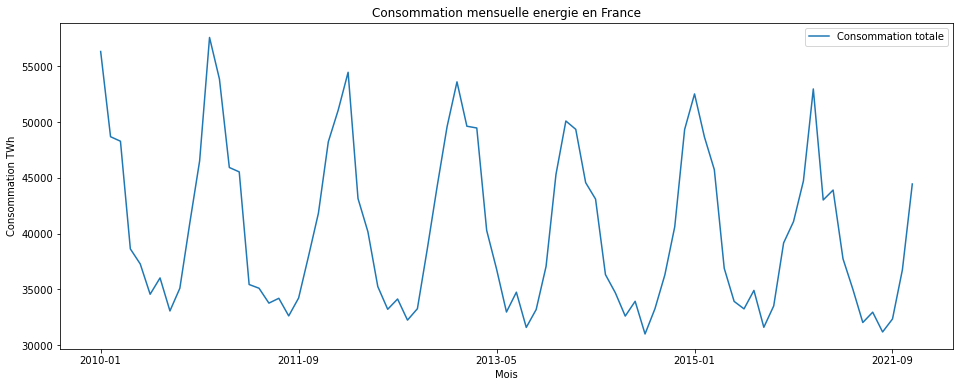

In [6]:
# visualtion temporelle de la consommation totale d'énergie
conso_df.plot(y="Consommation totale", figsize=(16,6))
plt.ylabel("Consommation TWh")
plt.title("Consommation mensuelle energie en France")
plt.savefig('P9_02_Graph/Consommation mensuelle energie en France.png')

On note sur ce graphique que la tendance de la consommation d'énergie est stable avec chaque année une saisonnalité . Cependant ces variations à l'intérieur d'une même année fluctuent énormément. Afin de confirmer ces éléments nous allons transformer les valeurs en logarithme pour valider nos hypothèses.

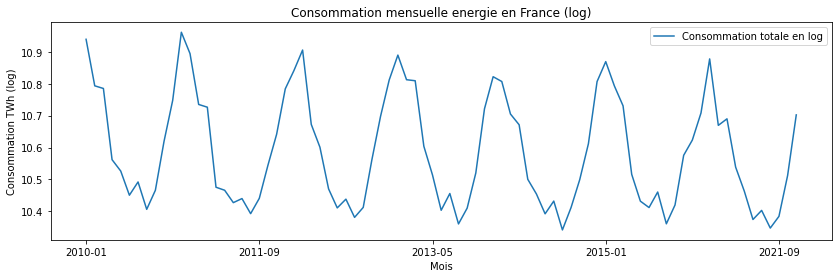

In [7]:
# Logarithme de la serie
np.log(conso_df['Consommation totale']).plot(figsize=(14,4))
plt.ylabel("Consommation TWh (log)")
plt.legend(labels=["Consommation totale en log"])
plt.title("Consommation mensuelle energie en France (log)")
plt.savefig('P9_02_Graph/Consommation mensuelle energie en France (log).png')

Ce graphique en Logarithme confirme nos hypothèses, en effet, on a la meme tendance et saisonalité que notre serie temporelle en valeurs réelles. 

<div class ="alert alert-block alert-success">

**Resultats:**  
    
    
- On a importé une table de données à partir de  https://www.rte-france.com/eco2mix/telecharger-les-indicateurs qui représente la consommation d'énérgie (éléctrique) en France de 2010 à 2021. Neanmoins, on une période sans données du 01.2016 au 12.2020.
    
    
- Eu egard, à la tendance stable, à la saisonnalité de notre serie temporelle ainsi qu'à ces ecarts entre les pics et les creux stables sur une période au cours du temps, on peut affirmer que nous sommes face à un modèle additif : $X_t = T_t + S_t + \epsilon_t$.
    

</div>

<a id='1.2'></a>
**1.2 Exploration et préparation des Données de chauffage**

<div class ="alert alert-block alert-info">

**Infos:**    
    
    
- On va importer les fichiers excel de la consommation de chauffage en DJU (degrés-jours-unifiés) par région  de  https://cegibat.grdf.fr/simulateur/calcul-dju afin de préparer nos données de l'effet température (dues au chauffage électrique).
    
    
- Notre table contiendra les degrés-jours-unifiés (DJU) par région qu'on transformera en moyenne nationale.Afin de pouvoir faire le rapprochement avec notre premier dataframe sur la consommation nationale d'energie.
    
 
- RAPPEL : La définition des Degrés Jours Unifiés : c'est une valeur représentative de l’écart entre la température d’une journée donnée et un seuil de température préétabli.Sommés sur une période, ils permettent de calculer les besoins de chauffage et de climatisation d’un bâtiment. 
    

</div>

[Haut de page](#sommaire)

In [8]:
# Chemin des fichiers
cwd = os.getcwd()
# selection conditionnelle des fichiers de chauffage dans le work directory
files = [file for file in os.listdir(cwd) if file.startswith("calcul_")]

In [9]:
# Concaténation des diffèrents fichiers régions
dju = pd.DataFrame()
# Pour chaque fichier dans files lire a partir de la 11 eme ligne et mettre en index la colonne 0 puis concat
for file in files :
    data = pd.read_excel(file, header=11, index_col=0)
    dju = pd.concat((dju,data))

# initialisation index
dju=dju.reset_index()
# definition de la colonne Annee
dju.rename(columns={dju.columns[0]:'Annee'}, inplace=True)
# Moyenne nationale
dju = dju.groupby(['Annee']).mean()
dju

JAN         FÉV         MAR         AVR         MAI        JUN  \
Annee                                                                          
2009   450.414286  338.257143  272.928571  156.057143   52.228571  18.057143   
2010   471.142857  355.371429  300.557143  156.542857  119.985714  18.928571   
2011   392.714286  288.514286  248.500000   87.157143   42.542857  29.271429   
2012   346.585714  442.600000  214.142857  200.100000   74.300000  21.885714   
2013   390.542857  378.657143  313.728571  196.385714  143.228571  32.957143   
2014   308.142857  270.928571  237.071429  129.400000   87.500000  11.542857   
2015   366.757143  355.600000  254.185714  139.828571   68.714286  13.885714   
2016   323.457143  290.971429  290.871429  191.271429   82.028571  18.742857   
2017   452.628571  257.142857  198.142857  173.700000   67.057143   9.842857   
2018   282.657143  386.885714  285.942857  116.714286   57.900000   5.885714   
2019   391.942857  272.671429  223.928571  171.271429  105.971429  24.585714   
2020   325.642857  237.228571  248.757143  104.942857   51.985714  23.085714   
2021   393.157143  257.942857  263.985714  203.728571  115.200000   3.357143   

             JUI        AOÛ        SEP         OCT         NOV         DÉC  \
Annee                                                                        
2009    6.742857   4.271429  23.042857  129.228571  204.314286  375.285714   
2010    0.771429  10.385714  51.671429  159.742857  276.442857  453.271429   
2011   15.757143  10.314286  20.485714  114.728571  200.828571  305.271429   
2012   13.042857   3.328571  43.185714  126.200000  251.557143  331.071429   
2013    1.042857   2.685714  28.228571   81.814286  284.428571  356.000000   
2014    4.800000  15.542857  17.685714   67.028571  191.257143  344.200000   
2015    5.271429   5.757143  50.571429  156.442857  191.071429  256.300000   
2016    6.542857   2.957143  10.614286  156.371429  256.885714  376.471429   
2017    2.671429   7.100000  52.771429   88.528571  276.142857  361.871429   
2018    0.000000   4.828571  20.557143  113.171429  244.142857  302.485714   
2019    0.485714   3.028571  22.014286   84.071429  269.457143  298.285714   
2020    3.485714   4.614286  31.357143  142.614286  220.485714  331.671429   
2021    0.000000   0.000000   0.000000    0.000000    0.000000    0.000000   

             Total  
Annee               
2009   2030.585714  
2010   2374.557143  
2011   1755.814286  
2012   2067.700000  
2013   2209.471429  
2014   1684.871429  
2015   1864.157143  
2016   2007.028571  
2017   1947.371429  
2018   1820.900000  
2019   1867.442857  
2020   1725.614286  
2021   1237.242857

In [10]:
dju.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13 entries, 2009 to 2021
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   JAN     13 non-null     float64
 1   FÉV     13 non-null     float64
 2   MAR     13 non-null     float64
 3   AVR     13 non-null     float64
 4   MAI     13 non-null     float64
 5   JUN     13 non-null     float64
 6   JUI     13 non-null     float64
 7   AOÛ     13 non-null     float64
 8   SEP     13 non-null     float64
 9   OCT     13 non-null     float64
 10  NOV     13 non-null     float64
 11  DÉC     13 non-null     float64
 12  Total   13 non-null     float64
dtypes: float64(13)
memory usage: 1.4 KB


In [11]:
# suppression colonne total
dju=dju.drop(columns=['Total'])
# on remplace les valeurs par une numerotation mensuelles
dju= dju.rename(columns={'JAN' : '1', 'FÉV' : '2', 'MAR' : '3','AVR' : '4', 'MAI' : '5','JUN' : '6',
                     'JUI' : '7', 'AOÛ' : '8', 'SEP' : '9','OCT' : '10','NOV' : '11','DÉC' : '12'})
dju

1           2           3           4           5          6  \
Annee                                                                          
2009   450.414286  338.257143  272.928571  156.057143   52.228571  18.057143   
2010   471.142857  355.371429  300.557143  156.542857  119.985714  18.928571   
2011   392.714286  288.514286  248.500000   87.157143   42.542857  29.271429   
2012   346.585714  442.600000  214.142857  200.100000   74.300000  21.885714   
2013   390.542857  378.657143  313.728571  196.385714  143.228571  32.957143   
2014   308.142857  270.928571  237.071429  129.400000   87.500000  11.542857   
2015   366.757143  355.600000  254.185714  139.828571   68.714286  13.885714   
2016   323.457143  290.971429  290.871429  191.271429   82.028571  18.742857   
2017   452.628571  257.142857  198.142857  173.700000   67.057143   9.842857   
2018   282.657143  386.885714  285.942857  116.714286   57.900000   5.885714   
2019   391.942857  272.671429  223.928571  171.271429  105.971429  24.585714   
2020   325.642857  237.228571  248.757143  104.942857   51.985714  23.085714   
2021   393.157143  257.942857  263.985714  203.728571  115.200000   3.357143   

               7          8          9          10          11          12  
Annee                                                                       
2009    6.742857   4.271429  23.042857  129.228571  204.314286  375.285714  
2010    0.771429  10.385714  51.671429  159.742857  276.442857  453.271429  
2011   15.757143  10.314286  20.485714  114.728571  200.828571  305.271429  
2012   13.042857   3.328571  43.185714  126.200000  251.557143  331.071429  
2013    1.042857   2.685714  28.228571   81.814286  284.428571  356.000000  
2014    4.800000  15.542857  17.685714   67.028571  191.257143  344.200000  
2015    5.271429   5.757143  50.571429  156.442857  191.071429  256.300000  
2016    6.542857   2.957143  10.614286  156.371429  256.885714  376.471429  
2017    2.671429   7.100000  52.771429   88.528571  276.142857  361.871429  
2018    0.000000   4.828571  20.557143  113.171429  244.142857  302.485714  
2019    0.485714   3.028571  22.014286   84.071429  269.457143  298.285714  
2020    3.485714   4.614286  31.357143  142.614286  220.485714  331.671429  
2021    0.000000   0.000000   0.000000    0.000000    0.000000    0.000000

In [12]:
# préparation liste pour df
chauff_df={'mois':[],'chauffage':[]}
# remplir le dictionnaire chauff_df 
for Année in dju.index.values:
    for mois in dju.columns:
        chauff_df['mois'].append(f"{Année}-{mois}")
        chauff_df['chauffage'].append(dju.loc[Année,mois])         
        
# Création du DataFrame 
chauff_df=pd.DataFrame(chauff_df)
#chauff_df['Mois']=pd.to_datetime(chauff_df['Mois'])
chauff_df

mois   chauffage
0     2009-1  450.414286
1     2009-2  338.257143
2     2009-3  272.928571
3     2009-4  156.057143
4     2009-5   52.228571
..       ...         ...
151   2021-8    0.000000
152   2021-9    0.000000
153  2021-10    0.000000
154  2021-11    0.000000
155  2021-12    0.000000

[156 rows x 2 columns]

In [13]:
# verification des données manquantes
manquant_chau=chauff_df.isna().sum()
manquant_chau

mois         0
chauffage    0
dtype: int64

In [14]:
# reinitialisation Index pour merge
conso_df=conso_df.reset_index()
# changement Dtype pour merege
conso_df['Mois']=pd.to_datetime(conso_df['Mois'])

In [15]:
# Application dtype Datetime variable Mois
chauff_df['mois']=pd.to_datetime(chauff_df['mois'])
# Jointure gauche droite des dataframe consommation totale energie et DJU chauffage 
df_1=conso_df.merge(chauff_df,left_on='Mois',right_on='mois')
# Définition de la variable mois comme index
df_1=df_1.drop(['mois'],axis=1).set_index('Mois')
# Filtrer valeurs supérieurs à 0
df_1 = df_1.loc[df_1['chauffage']>0,:]
# Exporter au format Csv
df_1.to_csv('df_1.csv')
# Lectue de la table df_1
df_1 = pd.read_csv("df_1.csv",index_col="Mois",parse_dates=False)

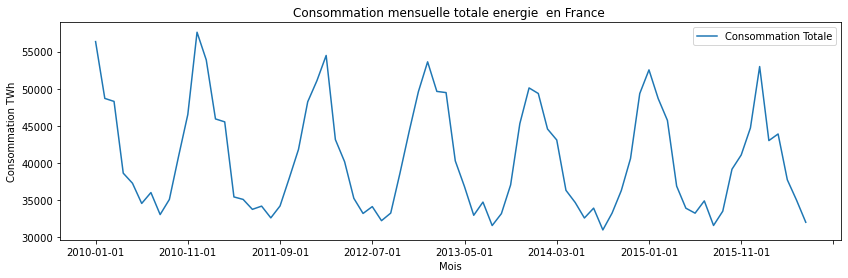

In [16]:
# Visualisation de la consommation totale DJU 
df_1['Consommation totale'].plot(figsize=(14,4),label="Consommation Totale")
plt.ylabel("Consommation TWh")
plt.title("Consommation mensuelle totale energie  en France ")
plt.legend()
plt.savefig('P9_02_Graph/Consommation mensuelle totale energie en France.png')

On note sur ce graphique une consommation mensuelle stable avec une saisonalité.

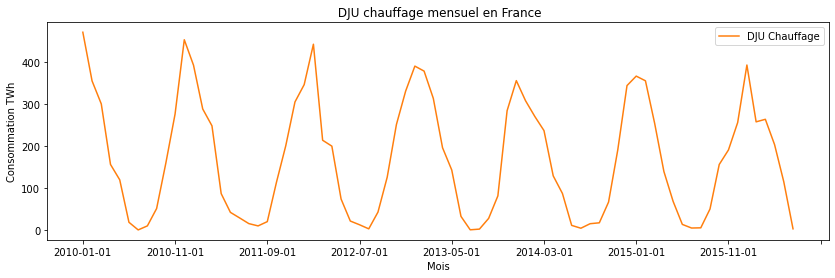

In [17]:
# Visualisation de la consommation mensuelle  DJU chaufage
df_1['chauffage'].plot(figsize=(14,4),label="DJU Chauffage", color='C1')
plt.ylabel("Consommation TWh")
plt.title(" DJU chauffage mensuel en France")
plt.legend()
plt.savefig('P9_02_Graph/ DJU chauffage mensuel en France.png')

On note sur ce graphique un DJU chauffage stable avec une saisonalité.

In [18]:
# Rename consommation totale
df_1.rename(columns={'Consommation totale': 'Consommation_totale'}, inplace=True)

In [19]:
# lecture des caracteristiques de la table
df_1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 78 entries, 2010-01-01 to 2021-06-01
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Consommation_totale  78 non-null     float64
 1   chauffage            78 non-null     float64
dtypes: float64(2)
memory usage: 1.8+ KB


<div class ="alert alert-block alert-success">

**Résultats:**  
        
- On a concatené tous les fichiers fichiers excel de la consommation de chauffage par région du 01.2009 au 06.2021 issues de https://cegibat.grdf.fr/simulateur/calcul-dju.
    
    
- Ensuite, on a preparé le dataframe obtenue pour une jointure avec le dataframe de la consommation total d'energie en France `conso_df` et créer un dataframe les regroupants `df_1`.
    
    
- Eu egard, à la tendance stable, à la saisonnalité de notre serie temporelle du DJU Chauffage ainsi qu'à ces ecarts entre les pics et les creux stables sur une période au cours du temps, on peut affirmer que nous sommes face à un modèle additif et qu'elle est sychrone avec la serie temporelle de la consommation d'energie en France.
    

</div>

<a id='1.3'></a>
#### 1.3  Correction de l'effet température par regression linéaire

[Haut de page](#sommaire)

<div class ="alert alert-block alert-info">

**Infos:**    
    

     
    
Pour cette question, on va simplement corriger notre serie de l'effet température par la tendance, on va essayer d'estimer le modèle de régression linéaire suivant avec la methode des moindres carrés:

$ \ $ 
    
$  \displaystyle \mathbb Y= \mathbb X \beta + \epsilon$    
    
    
$ \ $    
    
$ min_{(\alpha_0 ,...,\alpha_n ) \in \mathbb R^n}\sum_{T=1}^{T} (Y_t-T_t)^2$ 
    
    
$ \ $    
    
       
Pour ce faire, on va obtenir une estimation de $\hat T_t$ , afin de corriger notre serie temporelle.

$ \ $   
    
    
 $  \displaystyle Y_t^{Ctemp} = Y_t - \hat T_t$
    
$ \ $   
      
      
</div>

In [20]:
# Prise en compte des valeurs superieur à 0 pour omettre les données maquantes de juin à nov 2021
df_1 = df_1.loc[df_1['chauffage']>0,:]

In [21]:
# Définition de la la variable dependante 'Consommation totale' et la variable explicative 'chauffage'
y=df_1['Consommation_totale']
x=df_1.drop(columns=['Consommation_totale'])

In [22]:
# Régression linéaire 
reg= smf.ols('Consommation_totale ~ chauffage', data=df_1).fit()
print(reg.summary())

                             OLS Regression Results                            
Dep. Variable:     Consommation_totale   R-squared:                       0.960
Model:                             OLS   Adj. R-squared:                  0.960
Method:                  Least Squares   F-statistic:                     1827.
Date:                 Wed, 01 Jun 2022   Prob (F-statistic):           6.61e-55
Time:                         13:11:33   Log-Likelihood:                -678.08
No. Observations:                   78   AIC:                             1360.
Df Residuals:                       76   BIC:                             1365.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3.195e+04    260.307    122.74

On a obtenu une Pvalue = 6.61e-55, il existe donc à priori une influence de la variables explicative dju chauffage,  sur la variable à expliquer consommation totale. Le resultat est hautement significatif.

Notre modèle avec dju chauffage explique 96% de la variance.

In [23]:
# Test Kolmogorov-Smirnov d'adéquation des residus à une distribution normale
st.kstest(reg.resid, 'norm')

KstestResult(statistic=0.5256410256410257, pvalue=1.314544925693696e-20)

On rejette l'hypothèse H0. La distribution des residus ne suit pas une loi normale.

In [24]:
# affichage coeficient
print("Parameters: ", reg.params)

Parameters:  Intercept    31952.426164
chauffage       50.762831
dtype: float64


In [25]:
# coefficient dju chauffage
c = reg.params[1]

In [26]:
# calcul de la serie corrigée de l'effet température
x_cvs  = df_1['Consommation_totale'] - df_1['chauffage']*c

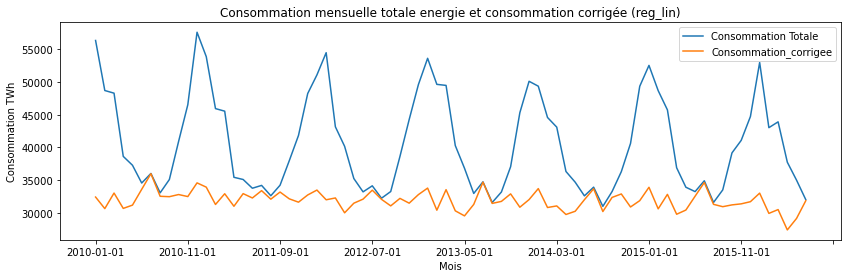

In [27]:
# on renomme consommation totale
x_cvs = x_cvs.rename("Consommation_corrigee")
# visualisation serie non corrigée
#x.plot(figsize=(14,4),label="Consommation Totale")
df_1['Consommation_totale'].plot(figsize=(14,4),label="Consommation Totale")
# visualisation serie corrigée
x_cvs.plot(figsize=(14,4),label='Consommation_corrigee')
# label ordonnée                                     
plt.ylabel("Consommation TWh")
# titre
plt.title("Consommation mensuelle totale energie et consommation corrigée (reg_lin)")
# legende
plt.legend()
plt.savefig('P9_02_Graph/Consommation mensuelle totale energie et consommation corrigée (reg_lin).png')

In [28]:
# Integration des série sous forme de Dataframe
serie_Corri = pd.DataFrame(x_cvs).reset_index() # Df serie Corrigée des variations

<div class ="alert alert-block alert-success">

**Résultat:**    
     
$ \ $    

Le graphique nous indique les niveaux de consommation mensuelle totale d’énergie et la consommation corrigée de l’effet de température (chauffage)en TWh entre janvier 2010 et décembre 2015.
     
$ \ $    
On obtient une tendance de la consommation corrigée qui traduit un niveau moyen qui semble stable.     

</div>

<a id='2'></a>
### 2. Désaisonnalisation de la consommation obtenue après correction, grâce aux moyennes mobiles.

<a id='2.1'></a>
#### 2.1 Préparation des données après correction

[Haut de page](#sommaire)

In [29]:
# création du dataframe des consommations corrigees pour effectuer la desaisonalisation
serie_Corrig_df= pd.DataFrame({'Mois':x_cvs.index, 'Consommation_corrigee':x_cvs.values})
# Definition de `Mois` comme index
serie_Corrig_df=serie_Corrig_df.set_index('Mois')
serie_Corrig_df

Consommation_corrigee
Mois                             
2010-01-01           32425.454826
2010-02-01           30658.340274
2010-03-01           33036.868590
2010-04-01           30690.441419
2010-05-01           31193.185479
...                           ...
2021-02-01           29930.090368
2021-03-01           30512.337833
2021-04-01           27405.160985
2021-05-01           29159.121883
2021-06-01           31861.581925

[78 rows x 1 columns]

In [30]:
# lecture des caracteristiques du df
serie_Corrig_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 78 entries, 2010-01-01 to 2021-06-01
Data columns (total 1 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Consommation_corrigee  78 non-null     float64
dtypes: float64(1)
memory usage: 1.2+ KB


<a id='2.2'></a>
#### 2.2 Méthode des moyennes mobiles

<div class ="alert alert-block alert-info">

**Infos:** 
    
    
On va effectuer une décompositions de notre serie temporelle en utilisant des moyennes mobiles. Pour ce faire on va utiliser le polynôme caractéristique de la moyenne mobile :
    
     
$ \ $    

$$  \displaystyle Θ(z) = \sum_{i=0}^{m1+m2} θ_{i−m1}z^i$$ 
    
$ \ $
       
    
Mettre en evidence les diffèrentes composantes de notre serie temporelle, et ainsi pouvoir corriger les variations saisonnières.Notre moyenne mobile ici est une combinaison linéaire d'instants passés et futurs, on va l'utiliser comme un filtre .
    
$ \ $   
    
$$MX_t=θ_{−m1}X_{t−m1}+…+θ{−1}X_{t−1}+θ_0X_t+θ1X_{t+1}+…+θ_{m2}X_{t+m2}$$
    
   
 $ \ $
    
soit notre serie temporel $X_t=T_t+S_t+ \varepsilon_t$
    
$ \ $
    
On applique une moyenne mobile M sur la série :
    
$ \ $
    
$$MX_t=MT_t+MS_t+ M\varepsilon_t$$
    
$ \ $
    
- Avec comme hypothèses :
    - $MT_t = T_t$, une tendance invariante
    - $MS_t = 0$, une saisonnalité absorbée
    - $M\varepsilon_t$,'faible' attenuation de la variance
    
$ \ $
  
Enfin, aprés avoir estimé la saisonnalité et obtenu les coefficients  saisonniers, on va les retrancher à notre serie après correction de l'effet temperature, pour obtenir notre serie temporelle desaisonnalisée.
    
$ \ $
    
$$ X_t^{CVS}=X_t− \hat S_t$$


</div>

[Haut de page](#sommaire)

In [31]:
# Décomposition saisonière
decomp_x = seasonal_decompose(
    x_cvs,
    model="additive",
    filt=None,
    period=12,
    two_sided=True,
    extrapolate_trend=0);

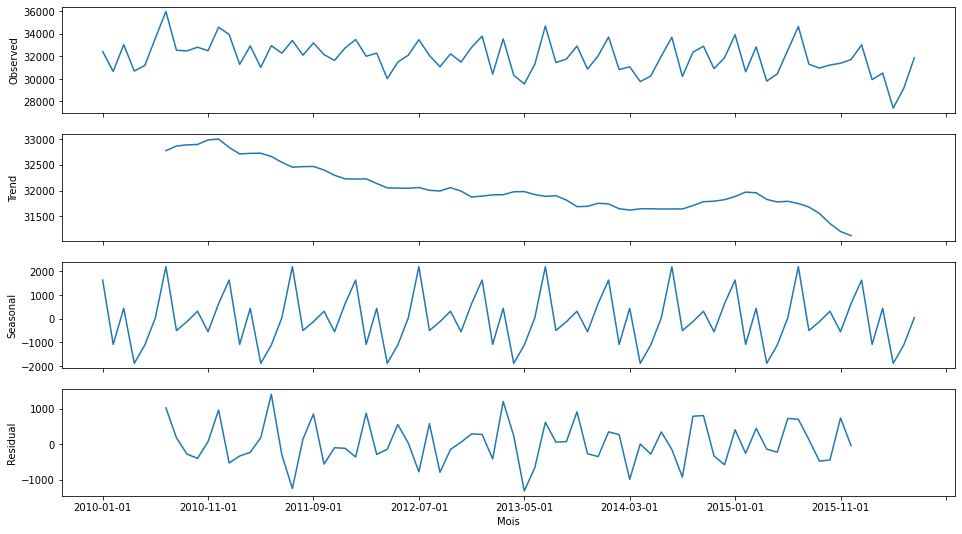

In [32]:
# Visualisation graphique de la décomposition saisonnière
fig, axes = plt.subplots(4, 1, sharex=True, figsize=(16, 9))
decomp_x.observed.plot(ax=axes[0], legend=False)
axes[0].set_ylabel('Observed')
decomp_x.trend.plot(ax=axes[1], legend=False)
axes[1].set_ylabel('Trend')
decomp_x.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Seasonal')
decomp_x.resid.plot(ax=axes[3], legend=False)
axes[3].set_ylabel('Residual')
plt.savefig('P9_02_Graph/ Décomposition de la consommation corrigée.png')
plt.show()

In [33]:
# On retranche les coef saisoniers aux consommation corrigées pour alimenter une nouvelle variable 'desaisonnalisee_corrigee'
serie_Corrig_df['desaisonnalisee_corrigee']= x_cvs.values - decomp_x.seasonal.values
serie_Corrig_df

Consommation_corrigee  desaisonnalisee_corrigee
Mois                                                       
2010-01-01           32425.454826              30793.909251
2010-02-01           30658.340274              31743.436785
2010-03-01           33036.868590              32597.962395
2010-04-01           30690.441419              32576.132238
2010-05-01           31193.185479              32305.619333
...                           ...                       ...
2021-02-01           29930.090368              31015.186879
2021-03-01           30512.337833              30073.431639
2021-04-01           27405.160985              29290.851804
2021-05-01           29159.121883              30271.555738
2021-06-01           31861.581925              31822.559647

[78 rows x 2 columns]

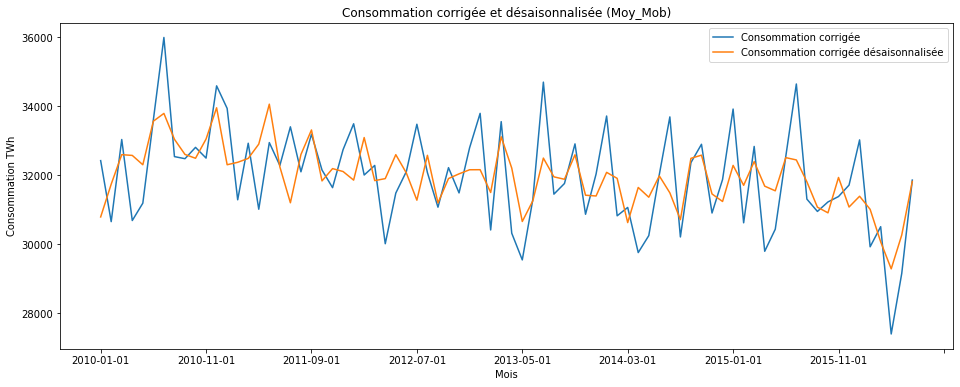

In [34]:
# visualisation serie consommation corrigée et désaisonalisée (CVS)
serie_Corrig_df['Consommation_corrigee'].plot(figsize=(16,6),label='Consommation corrigée')
# visualisation serie corrigée desaisonnalisé
serie_Corrig_df['desaisonnalisee_corrigee'].plot(figsize=(16,6),label='Consommation corrigée désaisonnalisée')                                     
# label ordonnée                                     
plt.ylabel("Consommation TWh")
# titre
plt.title("Consommation corrigée et désaisonnalisée (Moy_Mob)")
# legende
plt.legend()
plt.savefig('P9_02_Graph/Consommation corrigée et désaisonnalisée (Moy_Mob).png')

<div class ="alert alert-block alert-success">

**Résultat:**  
$ \ $    
Le graphique nous indique les niveaux de consommation corrigée et la consommation corrigée désaisonnalisée en TWh entre janvier 2010 et décembre 2015.

$ \ $ 
Notre série temporelle est invariante et absorbée à savoir rendue nulle par les moyennes mobiles. En somme, notre série temporelle conserve sa tendance. 

$ \ $ 
Quant au pouvoir de réduction de variance entre entrée et sortie, à savoir atténuer la perturbation (bruit blanc faible), on note peu d'atténuations de la variance. 
    

</div>

<a id='3'></a>
### 3. Prévision de la consommation corrigée de l'effet température sur un an avec la méthode de Holt Winters et SARIMA 

<a id='3.1'></a>
#### 3.1 Préparation des données corrigée de l'effet température

In [35]:
# copy DataFrame
serie_CVS_h=serie_Corrig_df.copy()
#serie_CVS_h = serie_CVS_h[['Mois','CVS']]
serie_CVS_h=serie_CVS_h.reset_index()
# Projection des variables de travail
serie_CVS_h=serie_CVS_h[['Mois','Consommation_corrigee']]
serie_CVS_h

Mois  Consommation_corrigee
0   2010-01-01           32425.454826
1   2010-02-01           30658.340274
2   2010-03-01           33036.868590
3   2010-04-01           30690.441419
4   2010-05-01           31193.185479
..         ...                    ...
73  2021-02-01           29930.090368
74  2021-03-01           30512.337833
75  2021-04-01           27405.160985
76  2021-05-01           29159.121883
77  2021-06-01           31861.581925

[78 rows x 2 columns]

In [36]:
# selection période sur laquelle on va travailler
serie_CVS_h = serie_CVS_h.loc[serie_CVS_h['Mois'] < '2014-01-01']
# Transformation date pour la visualisation
serie_CVS_h['Mois']=pd.to_datetime(serie_CVS_h['Mois'])
# selection de la serie corigée
y_hW= np.asarray(serie_CVS_h['Consommation_corrigee'])

<a id='3.2'></a>
#### 3.2 La méthode de Holt-Winters

<div class ="alert alert-block alert-info">

**Infos:** 
    
La méthode de Holt-Winters est effectivement la seul qui est vraiement pratiquable pour notre prévision car elle prend en compte la saisonnalité, en effet, si l'on considère seulement LES (lissage exponentielle simple) ou LED (lissage exponentielle double), on approxime notre serie temporelle soit par une constante soit par une droite.Ausi, comme demandé, on va utiliser la méthode de Holt-Winters pour effectuer notre prédiction. 

$ \ $    

Notre prévision est une fonction passé de notre serie et son objectif est de prévoir à la date T une série temporelle à un horizon $\ell$ à partir de $T$ observations $(X1,…,XT)$.
 
$ \ $
    
La méthode Holt-Winters consiste à supposer que $X_t$ est approximable au voisinage de $T$  par $aT+(t−T)bT+ST$ et $s$  étant la période du cycle saisonnier de la série temporelle.    
    
$ \ $     
      
$$\begin{cases} \hat a_T= (1−α)(XT− \hat S_{T−s}) + \alpha( \hat a_{T−1} + \hat b_{T−1} \\ \hat b_T=(1− \beta )( \hat a_T− \hat a_{T−1}) + \beta \hat b_{T−1} \\ \hat S_T= (1− \gamma)(XT− \hat a_T)+ \gamma \hat S_{T−s} \end{cases}$$

    
$ \ $     
      
    
Les parametres de la méthode sont $\alpha$, $\beta$ et  $\gamma$. Concernant la prévion on a : 

        
$ \ $     
  

$$\begin{cases} \hat X_{T(\ell)} = \hat a_{T+\ell} \hat b_T + \hat S_{T+\ell−s} \ \ \ \ si \ \ell∈{1,…,s}  \\  \hat X_{T(\ell)} = \hat a_{T+\ell} \hat b_T + \hat S_{T+\ell−2s}  \ \ \ \  si \ \ell∈{s+1,…,2s}  \\ {…} \end{cases}$$

</div>

[Haut de page](#sommaire)

In [37]:
# application de la méthode Holt-Winters
h_W = ExponentialSmoothing(y_hW,seasonal_periods=12, trend='add', seasonal='add').fit()
h_W_pred = h_W.forecast(12)

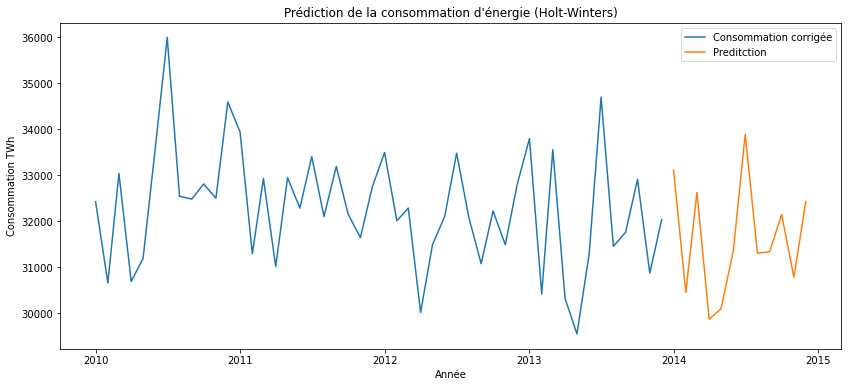

In [38]:
# visualisation serie consommation corrigée et désaisonalisée (CVS) methode Holt Winter
# parametre de taille graphique
plt.figure(figsize=(14,6))
# Variables à visualiser 'Mois' et 'prediction'
plt.plot(serie_CVS_h['Mois'],serie_CVS_h['Consommation_corrigee'], label='Consommation corrigée')
plt.plot(pd.date_range(serie_CVS_h.Mois[serie_CVS_h.shape[0]-1],periods=12, freq='M'), h_W_pred, label='Preditction')
# label ordonnée                                     
plt.ylabel('Consommation TWh')
# label abcisse
plt.xlabel('Année')
# titre
plt.title("Prédiction de la consommation d\'énergie (Holt-Winters)")
# legende
plt.legend()
plt.savefig('P9_02_Graph/Prédiction de la consommation d\'énergie (Holt-Winters).png')

On note sur ce graphique une prédiction qui s'inscrit dans la continuité d'une tendance stable de la consommation corrigée.

 On verifie si notre courbe de prediction resssemble à celle que l'on a sur la période 2014 .

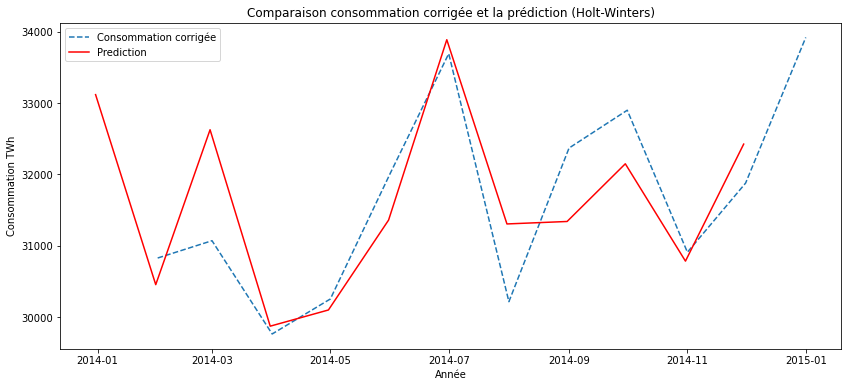

In [39]:
# Restriction à l'année 2014
serie_Corri['Mois']=pd.to_datetime(serie_Corri['Mois'])
serie_Corri_comp = serie_Corri.loc[serie_Corri['Mois'] > '2014-01-01']
serie_Corri_comp = serie_Corri_comp.loc[serie_Corri_comp['Mois'] < '2015-02-01']


# visualisation comparaison serie consommation corrigée et prediction
# parametre de taille graphique
plt.figure(figsize=(14,6))
# Variables à visualiser 'Mois' et 'prediction'
plt.plot(serie_Corri_comp['Mois'],serie_Corri_comp['Consommation_corrigee'], linestyle='--', label='Consommation corrigée')
plt.plot(pd.date_range(serie_CVS_h.Mois[serie_CVS_h.shape[0]-1],periods=12, freq='M'), h_W_pred,  color='r', label='Prediction')
# label ordonnée                                     
plt.ylabel('Consommation TWh')
# label abcisse
plt.xlabel('Année')
# titre
plt.title("Comparaison consommation corrigée et la prédiction (Holt-Winters)")
# legende
plt.legend()
plt.savefig('P9_02_Graph/Comparaison consommation corrigée et la prédiction (Holt-Winters).png')

In [40]:
# Root means squar error (erreur quadratique moyenne)
rmse = np.sqrt(((serie_Corri_comp['Consommation_corrigee']-h_W_pred)**2).mean())
rmse

1939.066941391059

In [41]:
# Mean Average Percentage error (erreur relative en moyenne)
mape=(np.abs(1-h_W_pred/serie_Corri_comp['Consommation_corrigee'])).mean()*100
mape

5.437494501715589

<div class ="alert alert-block alert-success">

**Résultat:**  

On note dans ce graphique annuel de comparaison une prédiction qui est très proche de la réalisation en bleu, on obtient une prédiction plutot cohérente. En outre, avec une RMSE de 1939.29 et une MAPE à 5.43 % notre resultat est acceptable.  
 
    
$ \ $  
        
Neanmoins, toutes les méthodes que nous venons de tester sont déterministes, à savoir, qu'à aucun moment il n'y a de notion de variable aléatoire, ces outils sont faibles, aussi, dans la partie suivante, nous allons essayer une modelisation stochastique d'une série temporelle en appliquant à nos données une structure aléatoire pour établir de bonnes prévisions.
    
</div>    

## <a id='3.3'></a>
#### 3.3 La méthode SARIMA

<div class ="alert alert-block alert-info">

**Infos:**    
 
$ \ $       
La démarche adoptée est la suivante :
    
$ \ $      

- stationnarisation (éventuellement),    
    
- Identification, estimation et validation de modèles
    
- Prévision à l'aide du modèle choisi,

- Analyse a posteriori de la prévision.
    

</div>

### Stationnarisation (éventuelle) de la série : 

**RAPPEL:** La stationnarité c'est la propriété d'une série temporelle à garder ses caractéristiques inchangées au passage du temps. Elle implique l'absence de tendance et de saisonnalité dans les données ainsi qu'une moyenne et une variance constantes pour la série temporelle.
 
Eu egard à la tendance et à la saisonnalité de notre serie ainsi qu'au faible nombre d'observations qu'on a pu collecter, on va travailler non pas sur la série mais sur des différences de la série avec l'operateur de différenciation $ \nabla_s^{D}$ au lieu de $X_t$:

$$ \nabla_s^{D}=(I−B_s)^D$$

In [42]:
#df_1['Mois']=pd.to_datetime(df_1['Mois'])
serie_Corri = serie_Corri.loc[serie_Corri['Mois'] < '2016-01-01']
serie_Corri=serie_Corri.set_index('Mois')

# stokage des valeurs dans variables series 'x' et 'y' en logarithme
x = serie_Corri
y = np.log(serie_Corri)

L'autocorrélogramme simple :

l'autocorrélogramme simple  noté $\rho$ permet de calculer la corrélation entre $X_t$ et $X_{t-h}$.c'est une simple normalisation de la fonction d'autocovariance.

$$\forall{h}∈ ℤ : \rho(h) = Corr(X_t,X_t−h) = \dfrac{\gamma (h)}{\gamma(0)}$$
    

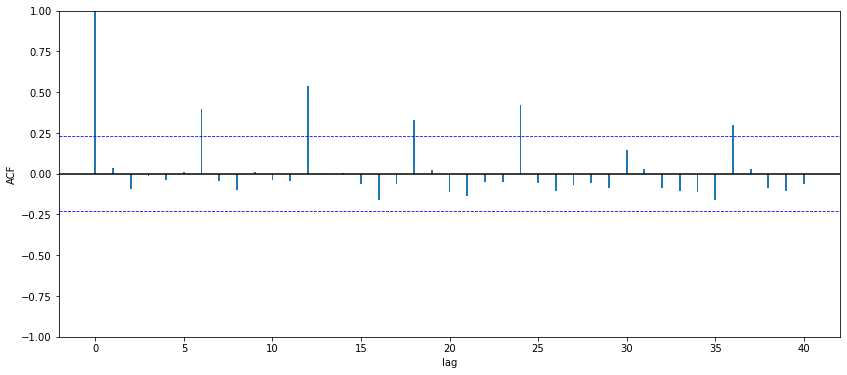

In [43]:
# Identification du nombre de décalage autorégressifs (AR) et le nombre de décalage de moyenne mobile (MA) avec la fonction d'autocorrélation simple 
y_len = len(y['Consommation_corrigee']) # variable nécessaire pour l'utilisation de plot_sortie_acf
# viusalisation graphique de l'autocorellation simple
plot_sortie_acf(acf(np.asarray(y['Consommation_corrigee'])), y_len)
plt.show()

La sortie ACF indique une décroissance sinusoïdale vers 0 avec des pics au retard 1,6,12,18,24 et 36 , aussi on va on va d'abord effectuer une différenciation $(I−B)$.

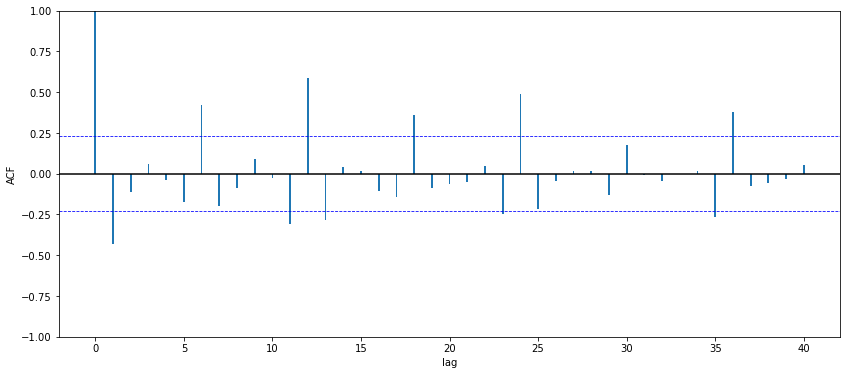

In [44]:
# 1ère Differenciation en tendance
y_dif1 = y['Consommation_corrigee'] - y['Consommation_corrigee'].shift(1)

plot_sortie_acf(acf(np.asarray(y_dif1[1:])), y_len)

La sortie ACF nous indique toujours une décroissance sinusoïdale vers 0, Aussi, on va effectuer  la différenciation $(I−B^{12})$ car on a un modele autoregressive d'ordre 12.

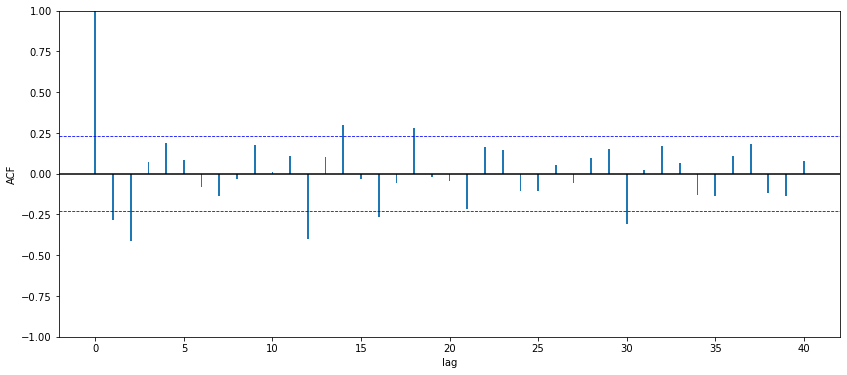

In [45]:
# 2 ème Différenciation  en saisonnalité
y_dif_1_12 = y_dif1 - y_dif1.shift(12)

plot_sortie_acf(acf(np.asarray(y_dif_1_12[13:])), y_len)

La sortie ACF de la série doublement différenciée decroit de manière sinusoïdale amortie et semble etre un autocorrélogramme simple empirique. On est ici face à un modèle SARIMA sur la série $(I−B)(I−B12)ln(X_t)$.

#### Identification, estimation et validation de modèles

On va s’appuier sur les autocorrélogrammes simple et partiels estimés

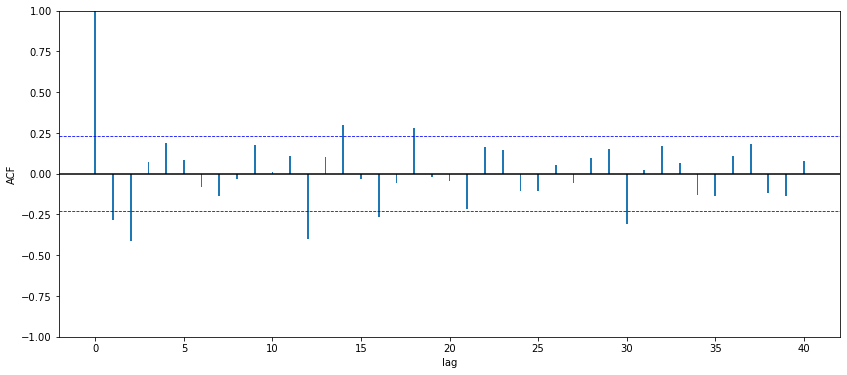

In [46]:
# Visualisation graphique de l'autorrélogramme simple differencié 12
y_dif_1_12 = y_dif1 - y_dif1.shift(12)

plot_sortie_acf(acf(np.asarray(y_dif_1_12[13:])), y_len)

Autocorrélogramme partiel : 

l'autocorrélogramme partiel noté $r$ permet de connaître la corrélation entre 2 instants éloignés d'un processus conditionnellement aux instants intermédiaires.

soit une relation entre $X_t$ et $X_{t-1}$.

$$r(0)=1$$

$$r(1)=\rho(1)$$
    

$$\forall{h} ∈ ℕ \backslash \{0,1\} : r(h) = Corr ( X_t,X_{t−h} / X_{t−1},…,X_{t−h+1})$$

$ \ $ 

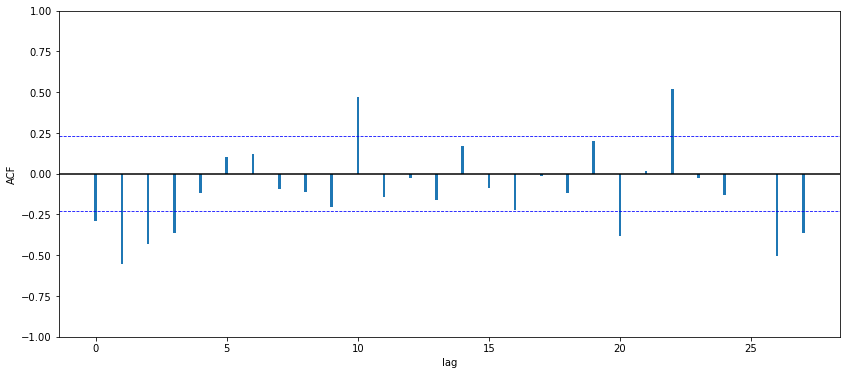

In [47]:
# Visualisation graphique de l'autorrélogramme partiel differencié 12
pacf_= pacf(y_dif_1_12[13:], nlags=28)
plot_sortie_acf(pacf_,y_len, pacf=True)

En somme,malgré une série doublement différenciée, il reste une structure dans la serie temporelle qu'on va essayer d'approximer sur la base de l'analyse du corrélogramme partiel de la diffèrence saisionnère d'ordre 12 qui présente des pics aux retards 1, 12 et 24 et de la fonction d'autocorrelation qui présente une decroissance sinusoïdale amortie.

#### Modèle 1

Eu egard aux autocorrélogrammes empiriques simples et partiels , on estime d'abord un modèle $SARIMA(1,1,1)(1,1,1)_{12}$. On écrit ce modèle :

$$(I−φ_{1}B)(I−φ′_{1}B^{12})(I−B)(I−B^{12})ln(X_{t})=(I+θ_{1}B)(I+θ′_{1}B^{12})ε_{t} $$

In [48]:
# importation 
from statsmodels.tsa.statespace.sarimax import *
from statsmodels.stats.diagnostic import acorr_ljungbox

model1 = SARIMAX(np.asarray(y['Consommation_corrigee']), order=(1,1,1), seasonal_order=(1,1,1,12))
results1 = model1.fit()                           # composante non saisonière  # composante saisonière 
print(results1.summary())

print('Retard : p-value')
for elt in [6, 12, 18, 24, 30, 36]:
    print('{} : {}'.format(elt, acorr_ljungbox(results1.resid, lags=elt)[1].mean()))

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                   72
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 127.559
Date:                            Wed, 01 Jun 2022   AIC                           -245.117
Time:                                    13:11:37   BIC                           -234.730
Sample:                                         0   HQIC                          -241.062
                                             - 72                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1235      0.148      0.834      0.404      -0.167       0.414
ma.L1         -0.9687      0.223   

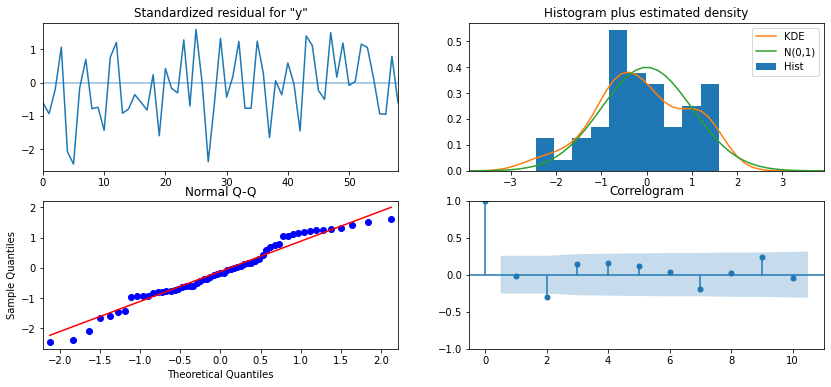

In [49]:
# Visualisation resultat modèle 1
results1.plot_diagnostics(figsize=(14,6))
plt.savefig('P9_02_Graph/Diagnostics Modèle 1.png')
plt.show()

Ce modèle ayant des paramètres non significatifs, on teste un deuxième modèle.

#### Modèle 2

Soit le modèle :
$$ (I−φ′_{1}B)(I−B)ln(X_{t})=(I+θ_{1}B)(I+θ′_{1}B)ε_{t} $$

In [50]:
model2 = SARIMAX(np.asarray(y['Consommation_corrigee']), order=(0,1,1), seasonal_order=(0,1,0,12))
results2 = model2.fit()                        # composante non saisonière  # composante saisonière 
print(results2.summary())

print('Retard : p-value')
for elt in [6, 12, 18, 24, 30, 36]:
    print('{} : {}'.format(elt, acorr_ljungbox(results2.resid, lags=elt)[1].mean()))

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                   72
Model:             SARIMAX(0, 1, 1)x(0, 1, [], 12)   Log Likelihood                 118.735
Date:                             Wed, 01 Jun 2022   AIC                           -233.469
Time:                                     13:11:38   BIC                           -229.314
Sample:                                          0   HQIC                          -231.847
                                              - 72                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9755      0.101     -9.631      0.000      -1.174      -0.777
sigma2         0.0010      

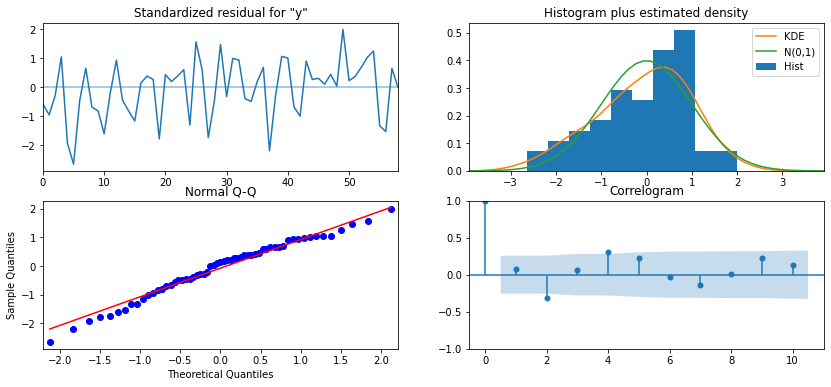

In [51]:
# Visualisation modèle 2
results2.plot_diagnostics(figsize=(14,6))
plt.savefig('P9_02_Graph/Diagnostics Modèle 2.png')
plt.show()

Les tests de significativité des paramètres et de blancheur du résidu sont validés au niveau 5%.

In [52]:
from scipy.stats import shapiro
shapiro(results2.resid)

ShapiroResult(statistic=0.19194024801254272, pvalue=5.682092224806409e-18)

Comme la valeur p est inférieure à 0,05, nous rejetons l'hypothèse nulle. La distribution des residus ne suit pas d'une loi normale.

<div class ="alert alert-block alert-success">
    
**Résultats :**   
  
Les tests de significativité des paramètres et La blancheur sont validés, excepté la normalité des résidus neanmoins le graphique QQ-plot nous indique une proximité à ne pas negliger. D'ailleurs, ce modèle semble etre le plus pertinent au regard des critères AIC, BIC et HQIC . Aussi, on va poursuivre notre analyse avec le modèle 2.
    
</div>

#### Prévision à l’aide du modèle 2 :

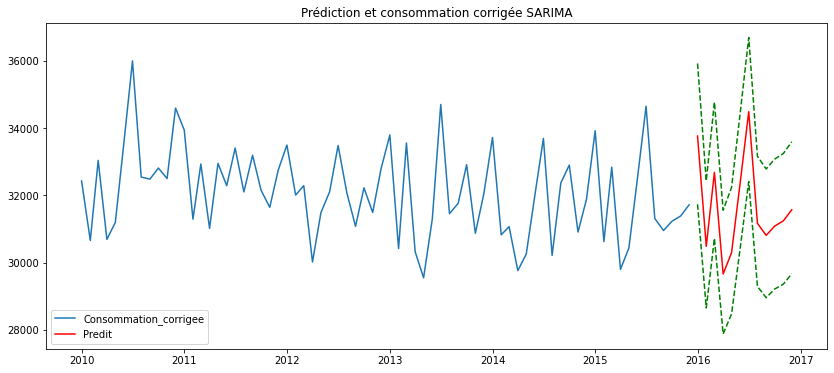

In [53]:
pred_model2 = results2.get_forecast(12)
pred = np.exp(pred_model2.predicted_mean)
pred_2 = [np.exp(elt[0]) for elt in pred_model2.conf_int(alpha=0.05)]
pred_u = [np.exp(elt[1]) for elt in pred_model2.conf_int(alpha=0.05)]

plt.figure(figsize=(14,6))
plt.plot(x['Consommation_corrigee'], label='Consommation_corrigee')
plt.plot(pd.date_range(x.index[len(x)-1], periods=12, freq='M'), pred, color='r', label='Predit')
plt.plot(pd.date_range(x.index[len(x)-1], periods=12, freq='M'), pred_2, color='g', linestyle='--')
plt.plot(pd.date_range(x.index[len(x)-1], periods=12, freq='M'), pred_u, color='g', linestyle='--')
plt.title("Prédiction et consommation corrigée SARIMA")
plt.legend()
plt.savefig('P9_02_Graph/Prédiction et consommation corrigée SARIMA.png')
plt.show()

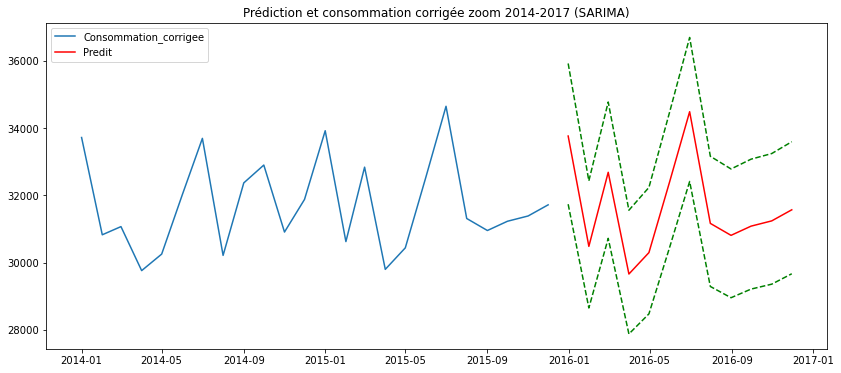

In [54]:
# zoom sur la periode
plt.figure(figsize=(14,6))
plt.plot(x['Consommation_corrigee']['2014':], label='Consommation_corrigee')
plt.plot(pd.date_range(x.index[len(x)-1], periods=12, freq='M'), pred, color='r', label='Predit')
plt.plot(pd.date_range(x.index[len(x)-1], periods=12, freq='M'), pred_2, color='g', linestyle='--')
plt.plot(pd.date_range(x.index[len(x)-1], periods=12, freq='M'), pred_u, color='g', linestyle='--')
plt.title("Prédiction et consommation corrigée zoom 2014-2017 (SARIMA)")
plt.legend()
plt.savefig('P9_02_Graph/Prédiction et consommation corrigée zoom 2014-2017 (SARIMA).png')
plt.show()

L'allure de nos graphiques semble cohérente au vu du passé de notre serie temporelle mais, on n'a pas de certitude sur la qualité de notre prévision aussi, aussi, on va effectuer une analyse à posteriori.

#### Analyse a posteriori

On va quantifier les écarts entre les prévisions et les réalisations. On va tronquer de la série l'année 2015 qu’on va chercher ensuite à prévoir à partir de l’historique 2010-2014.

In [55]:
# decoupage de notre dataframe
x_tronc = x[:'2014']
y_tronc = np.log(x_tronc)
x_a_prevoir = x['2015':]

In [56]:
# On vérifie notre modèle 1 sur la série tronquée
model2tronc = SARIMAX(np.asarray(y_tronc['Consommation_corrigee']), order=(0,1,1), seasonal_order=(0,1,0,12))
results2tronc = model2tronc.fit()
print(results2tronc.summary())

print('Retard : p-value')
for elt in [6, 12, 18, 24, 30, 36]:
    print('{} : {}'.format(elt, acorr_ljungbox(results2tronc.resid, lags=elt)[1].mean()))
    
shapiro(results2tronc.resid)

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                   60
Model:             SARIMAX(0, 1, 1)x(0, 1, [], 12)   Log Likelihood                  94.328
Date:                             Wed, 01 Jun 2022   AIC                           -184.656
Time:                                     13:11:39   BIC                           -180.956
Sample:                                          0   HQIC                          -183.264
                                              - 60                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9833      0.473     -2.077      0.038      -1.911      -0.056
sigma2         0.0010      

ShapiroResult(statistic=0.21557700634002686, pvalue=3.008494269035784e-16)

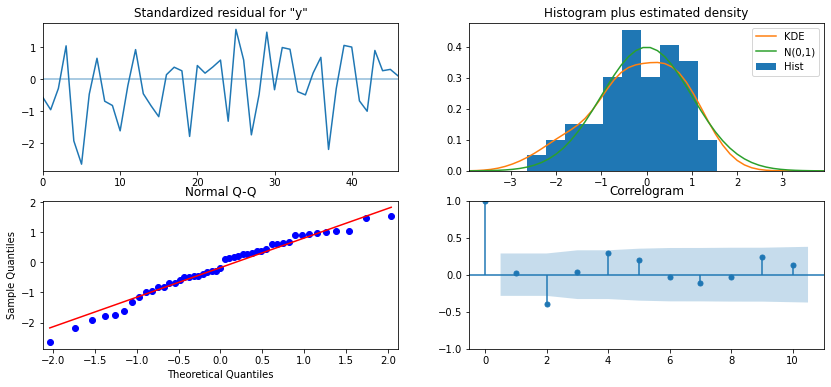

In [57]:
#Visualisation résultats modèletronc 2
results2tronc.plot_diagnostics(figsize=(14,6))
plt.savefig('P9_02_Graph/Diagnostics Modèle_tronc.png')
plt.show()

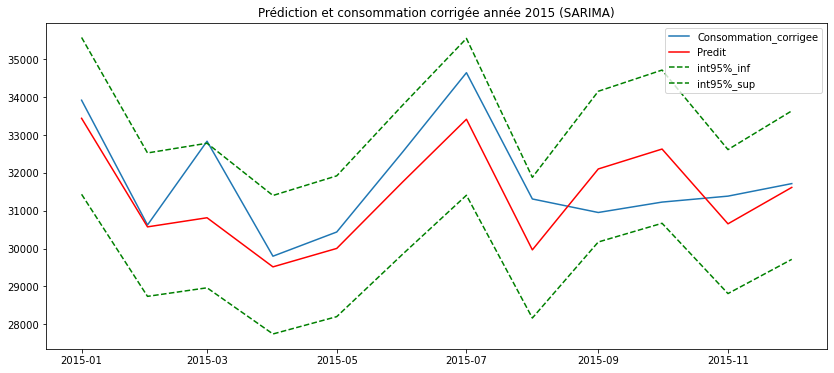

In [58]:
# Visualisationd de la prédiction
pred_model2tronc = results2tronc.get_forecast(12)
pred_tronc = np.exp(pred_model2tronc.predicted_mean)
pred_2_tronc = [np.exp(elt[0]) for elt in pred_model2tronc.conf_int(alpha=0.05)]
pred_u_tronc = [np.exp(elt[1]) for elt in pred_model2tronc.conf_int(alpha=0.05)]

plt.figure(figsize=(14,6))
plt.plot(x_a_prevoir, label='Consommation_corrigee')
plt.plot(x_a_prevoir.index, pred_tronc, color='r', label='Predit')
plt.plot(x_a_prevoir.index, pred_2_tronc, color='g', linestyle='--', label='int95%_inf')
plt.plot(x_a_prevoir.index, pred_u_tronc, color='g', linestyle='--', label='int95%_sup')
plt.title("Prédiction et consommation corrigée année 2015 (SARIMA)")
plt.legend()
plt.savefig('P9_02_Graph/Prédiction et consommation corrigée année 2015 (SARIMA).png')
plt.show()



On calcule les RMSE et MAPE.

$\displaystyle\ RMSE=\sqrt{ \frac {1}{T} \sum_{t=1}^{T} (x_t − \hat x_t)^2}$
    
$\displaystyle\ MAPE= \sqrt{\frac {1}{T} \sum_{t=1}^{T} ∣\frac {x_t− \hat x_t}{x_t}∣}$

In [59]:
# Root means squar error (erreur quadratique moyenne)
rmse = np.sqrt(((x_a_prevoir['Consommation_corrigee']-pred_tronc)**2).mean())
rmse

1014.491187584076

In [60]:
# Mean Average Percentage error (erreur relative en moyenne)
mape=(np.abs(1-pred_tronc/x_a_prevoir['Consommation_corrigee'])).mean()*100
mape

2.600879394695733

<div class ="alert alert-block alert-warning">
    
On note dans ce graphique une prédiction annuelle qui est proche de la réalisation en bleu et elle s'inscrit dans l'intervalle de confiance. On obtient une prédiction qui semble convenable avec des critères d'erreurs acceptables. 
    
Cependant, notre modèle dans cette analyse à posteriori n'est pas robuste car il perd de ses propriétés faute de données suffisantes.
    
</div>    

<div class ="alert alert-block alert-success">

**Résultats:**    
    
Avec la méthode SARIMA on a identifié, puis estimé notre modèle. Ensuite, on a utilisé notre modèle pour effectuer des  previsions qui semblaient à priori convenables. 
    
    
Cependant, lors de l'analyse effectuée à posteriori notre modèle n'a pas conservé certaines de ses propriétés faute de données suffisantes.
    
    
Aussi, la prudence est de mise car notre modèle doit s'appuyer sur un nombre suffisant d'observations pour satisfaire les différentes mesures nécessaires à la validité du modèle.
    
En somme, les modèles analysés sont peu concluants car les resultats des mesures effectuées ne sont pas satisfaisants. En outre, la faible quantité de données disponible limite le travail sur les modèles.
    
</div>

## Références

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_excel.html

https://stackoverflow.com/questions/16504975/error-unsupported-format-or-corrupt-file-expected-bof-record

https://stackoverflow.com/questions/47405628/bokeh-utf8-codec-cant-decode-byte-0xe9-unexpected-end-of-data

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html

https://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.seasonal_decompose.html

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.asfreq.html

https://stackoverflow.com/questions/64617482/valueerror-you-must-specify-a-period-or-x-must-be-a-pandas-object-with-a-dateti

https://openclassrooms.com/fr/courses/4525371-analysez-et-modelisez-des-series-temporelles/5001626-decouvrez-des-algorithmes-de-traitement-des-moyennes-mobiles

https://perso.math.univ-toulouse.fr/jydauxoi/files/2017/04/poly_eleves.pdf

https://eric.univ-lyon2.fr/~jjacques/Download/Cours/ST-Cours.pdf

https://searchcode.com/codesearch/view/86129185/

https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/

https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_sarimax_stata.html